<h1><center><font size="6">Chat vs Chien</font></center></h1>


<center><img src="https://www.theladders.com/wp-content/uploads/dog-cat-190709-1000x563.jpg" width="900"></img></center>

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.mixed_precision import set_global_policy
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from glob import glob
import random
from PIL import Image
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import mixed_precision

print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
mixed_precision.set_global_policy("mixed_float16")  # Speed up training on GPU


2025-04-23 23:53:22.292571: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745452402.492447      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745452402.544491      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow Version: 2.18.0
Num GPUs Available: 1


# EDA

In [2]:
import os
import pandas as pd

# Dataset directory path
directory_path = "/kaggle/input/cats-dogs-dataset/CatDog2"

# Dictionary to store counts
data = []

# Iterate through each split (train, test, val)
for split in ['train', 'val']:
    split_path = os.path.join(directory_path, split)
    if os.path.exists(split_path):
        # Iterate through each class (chat, chien)
        for class_name in ['chat', 'chien']:
            class_path = os.path.join(split_path, class_name)
            if os.path.exists(class_path):
                # Count images
                image_count = len([f for f in os.listdir(class_path) 
                                 if os.path.isfile(os.path.join(class_path, f))])
                data.append({
                    'Split': split,
                    'Class': class_name,
                    'Class': 'Cat' if class_name == 'chat' else 'Dog',
                    'Image Count': image_count
                })

# Convert to DataFrame
df = pd.DataFrame(data)

# Pivot for better visualization
pivot_df = df.pivot_table(index=['Split', 'Class'], 
                         values='Image Count', 
                         aggfunc='sum').reset_index()

# Display results
print("Detailed Counts:")
print(df)
print("\nSummary View:")
print(pivot_df)

Detailed Counts:
   Split Class  Image Count
0  train   Cat          280
1  train   Dog          280
2    val   Cat           60
3    val   Dog           60

Summary View:
   Split Class  Image Count
0  train   Cat          280
1  train   Dog          280
2    val   Cat           60
3    val   Dog           60


## Summary Statistics

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Display basic statistics
print(df.describe())


       Image Count
count     4.000000
mean    170.000000
std     127.017059
min      60.000000
25%      60.000000
50%     170.000000
75%     280.000000
max     280.000000


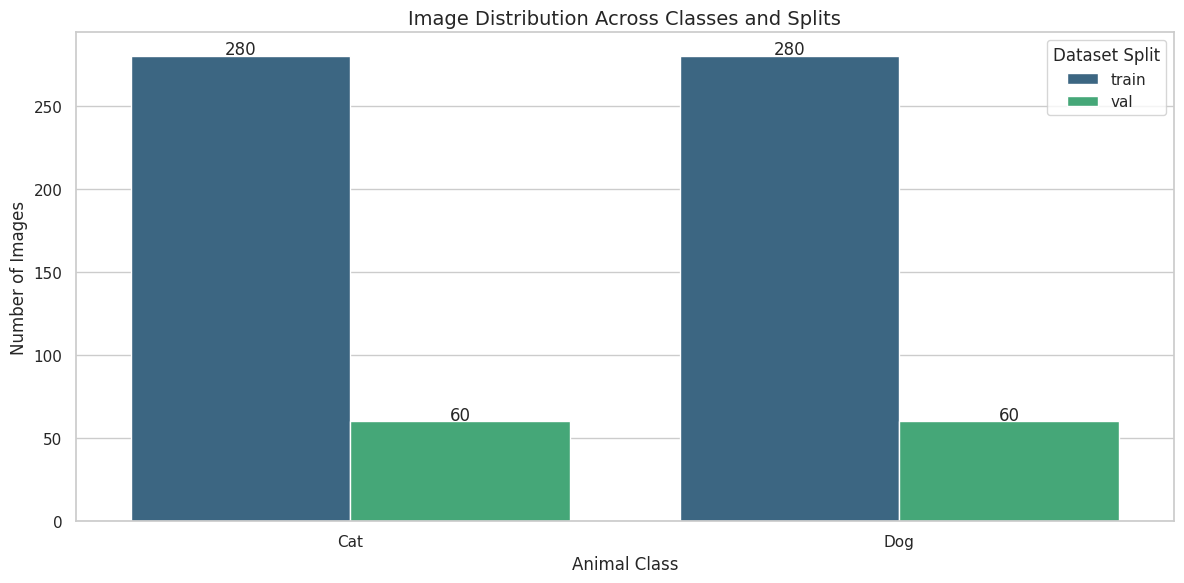

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set plot style and size
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Create the bar plot with hue for splits
ax = sns.barplot(x="Class", y="Image Count", hue="Split", data=df, palette="viridis")

# Add value labels on top of each bar
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

# Improve labels and title
plt.xlabel("Animal Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Image Distribution Across Classes and Splits", fontsize=14)
plt.legend(title='Dataset Split')

# Adjust layout and display plot
plt.tight_layout()
plt.show()

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import defaultdict

# Dataset directory path
directory_path = "/kaggle/input/cats-dogs-dataset/CatDog2"

# Initialize data collection
stats = {
    'extensions': defaultdict(int),
    'dimensions': [],
    'class_stats': defaultdict(lambda: {'count': 0, 'dimensions': []})
}

# Function to process images
def process_image(filepath, class_name, split):
    try:
        with Image.open(filepath) as img:
            width, height = img.size
            stats['dimensions'].append((width, height))
            stats['class_stats'][(split, class_name)]['dimensions'].append((width, height))
            stats['class_stats'][(split, class_name)]['count'] += 1
    except Exception as e:
        print(f"Error processing {filepath}: {str(e)}")

# Walk through directory structure
for split in ['train', 'val']:
    split_path = os.path.join(directory_path, split)
    if os.path.exists(split_path):
        for class_name in ['chat', 'chien']:
            class_path = os.path.join(split_path, class_name)
            if os.path.exists(class_path):
                for filename in os.listdir(class_path):
                    filepath = os.path.join(class_path, filename)
                    if os.path.isfile(filepath):
                        ext = os.path.splitext(filename)[1].lower()
                        stats['extensions'][ext] += 1
                        process_image(filepath, 'Cat' if class_name == 'chat' else 'Dog', split)

# Create DataFrames for visualization
ext_df = pd.DataFrame(list(stats['extensions'].items()), columns=['Extension', 'Count'])
dim_df = pd.DataFrame(stats['dimensions'], columns=['Width', 'Height'])
class_df = pd.DataFrame([
    {'Split': split, 'Class': cls, 'Count': data['count'], 
     'Avg Width': sum(w for w, h in data['dimensions'])/len(data['dimensions']),
     'Avg Height': sum(h for w, h in data['dimensions'])/len(data['dimensions'])}
    for (split, cls), data in stats['class_stats'].items()
])



/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)


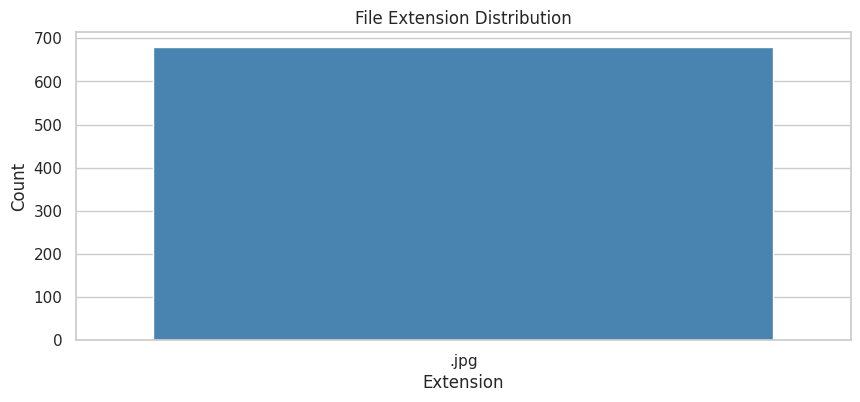

In [6]:
# Visualization 1: File Extensions
plt.figure(figsize=(10, 4))
sns.barplot(x='Extension', y='Count', data=ext_df, palette='Blues_d')
plt.title('File Extension Distribution')
plt.show()

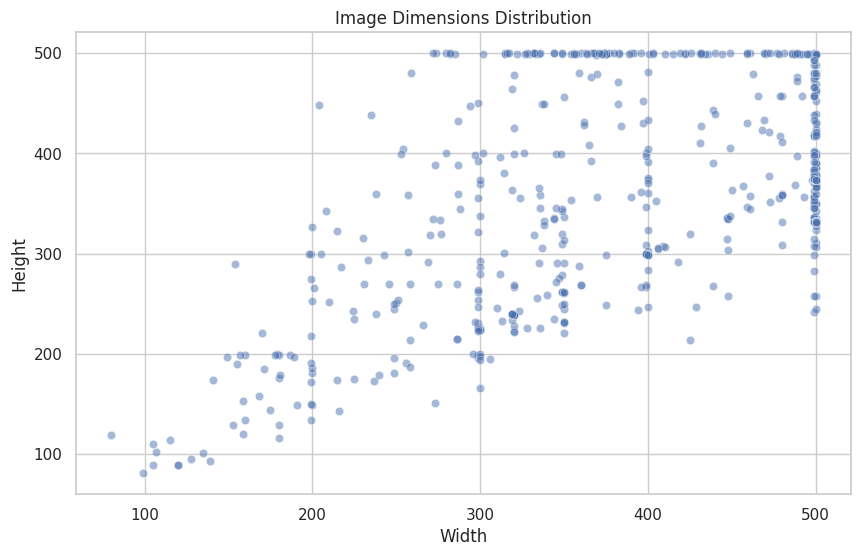

In [7]:
# Visualization 2: Image Dimensions Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Width', y='Height', data=dim_df, alpha=0.5)
plt.title('Image Dimensions Distribution')
plt.show()



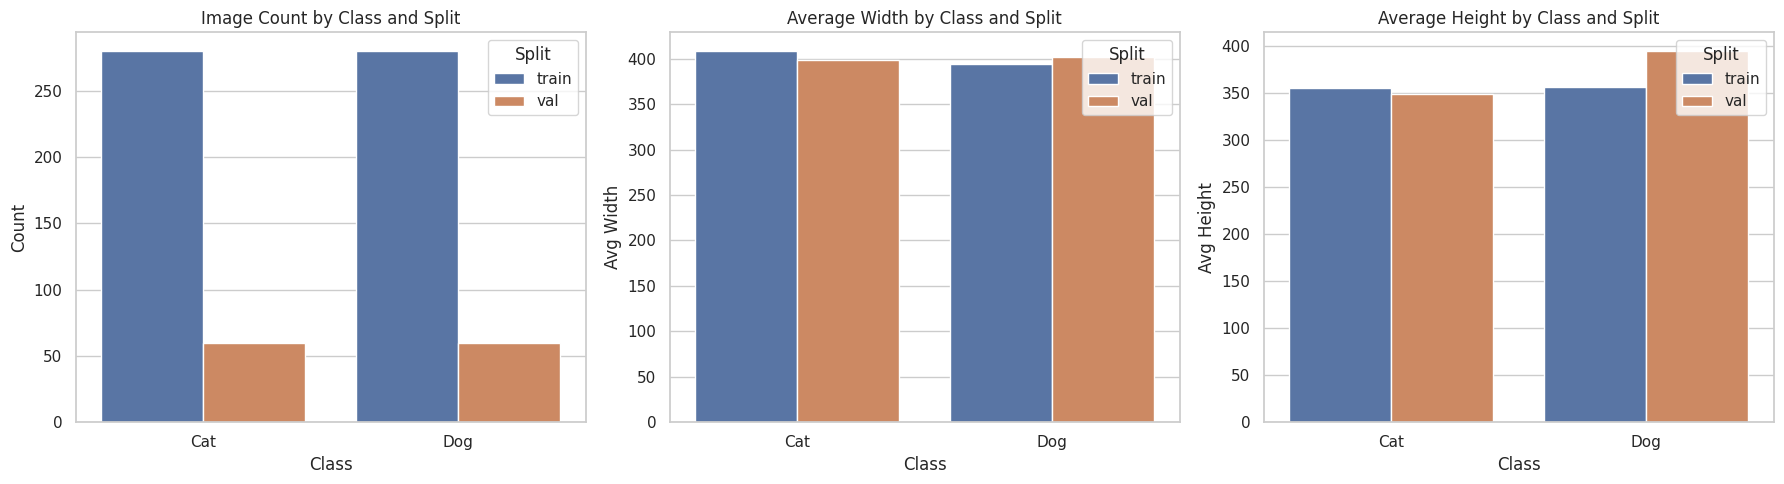

In [8]:
# Visualization 3: Class Statistics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.barplot(x='Class', y='Count', hue='Split', data=class_df, ax=axes[0])
axes[0].set_title('Image Count by Class and Split')

sns.barplot(x='Class', y='Avg Width', hue='Split', data=class_df, ax=axes[1])
axes[1].set_title('Average Width by Class and Split')

sns.barplot(x='Class', y='Avg Height', hue='Split', data=class_df, ax=axes[2])
axes[2].set_title('Average Height by Class and Split')

plt.tight_layout()
plt.show()



In [9]:
# Display summary tables
print("\n=== File Extensions Summary ===")
print(ext_df.sort_values('Count', ascending=False))

print("\n=== Image Dimensions Summary ===")
print(dim_df.describe())

print("\n=== Class Statistics ===")
print(class_df)


=== File Extensions Summary ===
  Extension  Count
0      .jpg    680

=== Image Dimensions Summary ===
            Width      Height
count  680.000000  680.000000
mean   401.338235  358.408824
std    108.073914   98.495788
min     80.000000   81.000000
25%    320.000000  300.000000
50%    433.000000  374.000000
75%    499.000000  419.250000
max    500.000000  500.000000

=== Class Statistics ===
   Split Class  Count   Avg Width  Avg Height
0  train   Cat    280  408.610714  354.914286
1  train   Dog    280  394.653571  356.300000
2    val   Cat     60  398.266667  348.700000
3    val   Dog     60  401.666667  394.266667


---
### **Analyse des Extensions de Fichiers**
- **Toutes les images sont en .jpg** (680 fichiers)  
  → Format uniforme, idéal pour le traitement  
  → Aucun problème de compatibilité à prévoir

### **Analyse des Dimensions des Images**
- **Grande variabilité** :
  - Largeur moyenne : 401px (±108)  
  - Hauteur moyenne : 358px (±98)  
  → Écart-type élevé indiquant des tailles hétérogènes

- **Plage extrême** :
  - Mini : 80x81px (risque de qualité insuffisante)  
  - Maxi : 500x500px (taille standard correcte)  
  → Nécessité potentielle de redimensionnement pour l'uniformisation

- **Dimensions médianes** :
  - 433x374px  
  → 50% des images sont plus grandes que cette taille

### **Répartition par Classe et Dataset**
**Jeu d'entraînement (train)** :
- **Chats** : 280 images (408x354px en moyenne)  
- **Chiens** : 280 images (394x356px en moyenne)  
→ **Équilibre parfait** entre classes  
→ Légère différence de taille moyenne (chats +14px en largeur)

**Jeu de validation (val)** :
- **Chats** : 60 images (398x348px)  
- **Chiens** : 60 images (401x394px)  
→ **Déséquilibre de hauteur** notable (+45px pour les chiens)  
→ À surveiller lors de l'évaluation des performances

### **Recommandations** :
1. **Pré-traitement conseillé** :
   - Redimensionnement à une taille fixe (ex: 400x400px)  
   - Recadrage centre pour conserver les ratios

2. **Vérification qualité** :
   - Contrôler manuellement les images <150px  
   - Vérifier le déséquilibre de hauteur en validation

3. **Augmentation de données** :
   - Pertinent pour les chiens du jeu de validation  
   - Rotation/zoom pour compenser la variabilité de taille
---

TRAIN - Cat: cat.331.jpg (499x480)
TRAIN - Cat: cat.24.jpg (500x374)
TRAIN - Cat: cat.49.jpg (180x129)
TRAIN - Cat: cat.198.jpg (499x375)
TRAIN - Dog: dog.368.jpg (392x500)
TRAIN - Dog: dog.190.jpg (499x375)
TRAIN - Dog: dog.289.jpg (410x499)
TRAIN - Dog: dog.391.jpg (200x327)
VAL - Cat: cat.323.jpg (499x384)
VAL - Cat: cat.212.jpg (332x319)
VAL - Cat: cat.125.jpg (499x480)
VAL - Cat: cat.314.jpg (500x360)
VAL - Dog: dog.253.jpg (500x418)
VAL - Dog: dog.273.jpg (371x500)
VAL - Dog: dog.118.jpg (297x398)
VAL - Dog: dog.354.jpg (286x215)


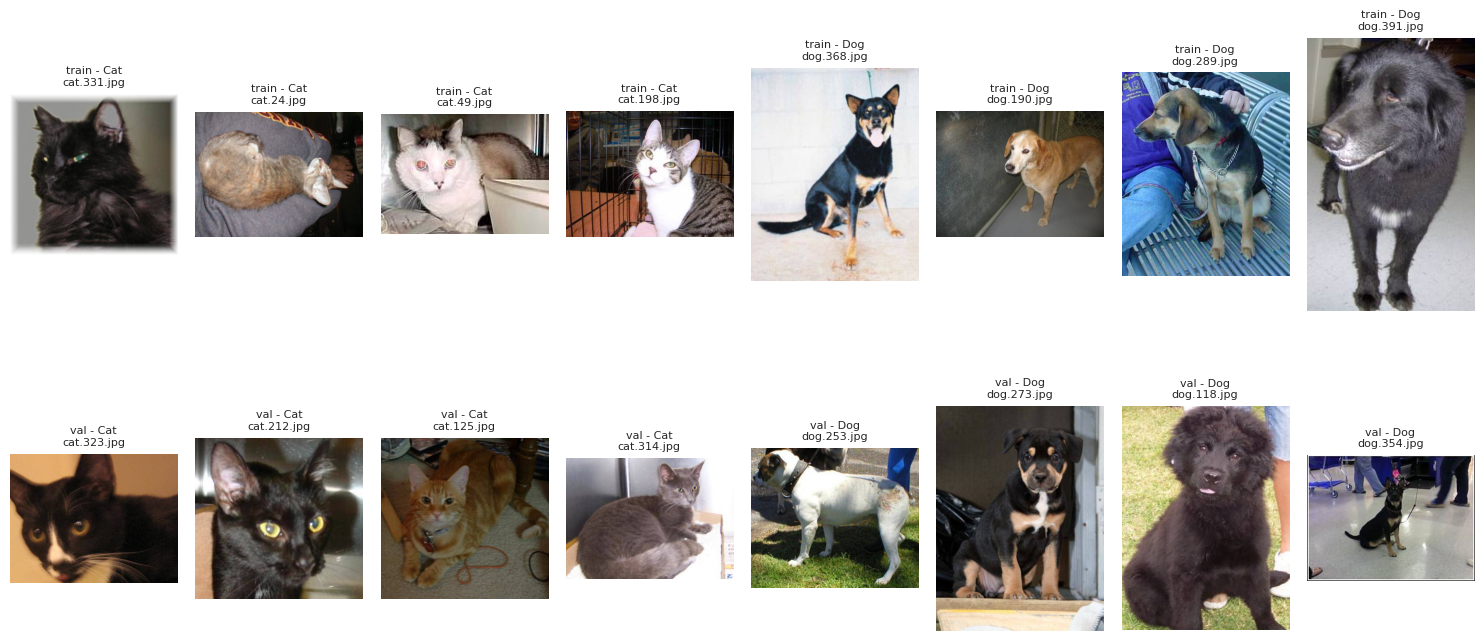

In [10]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random

# Configuration
dataset_path = "/kaggle/input/cats-dogs-dataset/CatDog2"
splits = ['train', 'val']  # We'll show both validation and test
classes = {'chat': 'Cat', 'chien': 'Dog'}
samples_per_class = 4  # Number of samples to display per class

plt.figure(figsize=(15, 8))

for i, split in enumerate(splits, 1):
    for j, (class_fr, class_en) in enumerate(classes.items(), 1):
        # Get the path to images
        class_path = os.path.join(dataset_path, split, class_fr)
        if not os.path.exists(class_path):
            continue
            
        # Get random sample images
        all_images = os.listdir(class_path)
        sample_images = random.sample(all_images, min(samples_per_class, len(all_images)))
        
        # Display each sample
        for k, img_name in enumerate(sample_images, 1):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            
            # Create subplot
            plt.subplot(len(splits), samples_per_class*len(classes), (i-1)*samples_per_class*len(classes) + (j-1)*samples_per_class + k)
            plt.imshow(img)
            plt.title(f"{split} - {class_en}\n{img_name}", fontsize=8)
            plt.axis('off')
            
            # Print image info
            print(f"{split.upper()} - {class_en}: {img_name} ({img.size[0]}x{img.size[1]})")

plt.tight_layout()
plt.show()

---
1. Constat actuel
L'ensemble de données contient 680 images au format .jpg, avec des dimensions très variées :

Largeur moyenne : ~401 pixels (min : 80, max : 500)

Hauteur moyenne : ~358 pixels (min : 81, max : 500)

Les tailles sont hétérogènes, ce qui peut nuire à la performance d'un réseau de neurones convolutionnel (CNN) qui attend une taille fixe en entrée.

2. Problème
Les CNN nécessitent des images de dimensions constantes pour fonctionner efficacement. Si on ne traite pas cette disparité :

L'entraînement échouera ou sera inefficace.

Des distorsions peuvent apparaître si on redimensionne brutalement les images.

3. Solution proposée
Utiliser une approche de redimensionnement avec préservation du ratio d’aspect, suivie d’un remplissage (padding) pour uniformiser les dimensions.

🔹 Taille cible : 224x224 pixels
Taille standard pour la plupart des architectures CNN (ResNet, MobileNet, etc.)

Bon compromis entre qualité d’image et performance computationnelle.

🔹 Étapes à suivre :
Redimensionner chaque image de sorte que son plus grand côté corresponde à 224 pixels, tout en gardant le ratio largeur/hauteur.

Ajouter des bordures (pixels noirs ou blancs) sur les côtés restants pour obtenir une image finale carrée de 224x224.

Appliquer une augmentation de données pendant l’entraînement (rotations, flips, zooms, etc.) pour améliorer la généralisation.

---

# Model training

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetV2S  # Best balance of accuracy/size
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import tensorflow.keras.backend as K

def build_model():
    # base_model = EfficientNetV2S(
    #     weights='imagenet',
    #     include_top=False,
    #     input_shape=(384, 384, 3),
    #     pooling=None
    # )
    # base_model.trainable = False

    base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
    base_model.trainable = False  # freeze initial layers
    
    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # binaire : chat vs chien
    ])
    return model

model = build_model()

I0000 00:00:1745452427.600020      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation strategy for your 680-image dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for validation - Normalization only

val_generator = val_datagen.flow_from_directory(
    '/kaggle/input/cats-dogs-dataset/CatDog2/val',  # Your validation folder
    target_size=(384, 384),  # Must match training size
    batch_size=32,
    class_mode='binary',      # Binary classification
    classes=['chat', 'chien'], # Matches your French subfolders
    shuffle=False            # Important for validation metrics
)
# Flow from directory with your French folder names
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/cats-dogs-dataset/CatDog2/train',
    target_size=(384, 384),  # EffNetV2S optimal size
    batch_size=32,
    class_mode='binary',      # Cat/Dog is binary
    classes=['chat', 'chien'] # Match your French dirs
)

Found 120 images belonging to 2 classes.
Found 560 images belonging to 2 classes.


In [13]:
# model = build_model()

# # Custom optimizer configuration
# optimizer = tf.keras.optimizers.AdamW(
#     learning_rate=1e-4,  # Lower than default for fine-tuning
#     weight_decay=1e-5     # Regularization
# )

# # model.compile(
# #     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
# #     loss='binary_crossentropy',
# #     metrics=['accuracy']
# # )

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(1e-5),  # learning rate plus bas
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(train_labels),
#     y=train_labels
# )


# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
#     ModelCheckpoint('best_model.h5', save_best_only=True),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)
# ]


# history = model.fit(
#     train_generator,
#     epochs=50,
#     validation_data=val_generator,
#     callbacks=callbacks
# )

In [14]:
# import tensorflow as tf
# from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
# from tensorflow.keras.applications import EfficientNetV2S
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

# # 1. Precision-optimized model
# def build_model():
#     base_model = EfficientNetV2S(
#         weights='imagenet',
#         include_top=False,
#         input_shape=(300, 300, 3),
#         pooling='avg'  # Better than GlobalAveragePooling2D for EfficientNet
#     )
    
#     # Strategic unfreezing
#     base_model.trainable = False
#     for layer in base_model.layers[-20:]:
#         layer.trainable = True

#     inputs = tf.keras.Input(shape=(300, 300, 3))
#     x = base_model(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.5)(x)
#     x = layers.Dense(256, activation='swish',  # Better than relu
#                    kernel_regularizer=regularizers.l2(0.01))(x)
#     outputs = layers.Dense(1, activation='sigmoid')(x)
    
#     return models.Model(inputs, outputs)

# # 2. Enhanced data pipeline
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=35,
#     width_shift_range=0.3,
#     height_shift_range=0.3,
#     shear_range=0.25,
#     zoom_range=0.3,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='reflect',
#     brightness_range=[0.7, 1.3],
#     channel_shift_range=50.0  # Color variation
# )

# val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# # 3. Generators with mixed precision
# target_size = (300, 300)
# train_generator = train_datagen.flow_from_directory(
#     '/kaggle/input/cats-dogs-dataset/CatDog2/train',
#     target_size=target_size,
#     batch_size=32,
#     class_mode='binary',
#     classes=['chat', 'chien']
# )

# val_generator = val_datagen.flow_from_directory(
#     '/kaggle/input/cats-dogs-dataset/CatDog2/val',
#     target_size=target_size,
#     batch_size=32,
#     class_mode='binary',
#     classes=['chat', 'chien']
# )

# # 4. Advanced class weighting
# train_labels = train_generator.classes
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(train_labels),
#     y=train_labels
# )
# class_weight_dict = {0: class_weights[0]*1.1,  # Extra weight for cats
#                      1: class_weights[1]}

# # 5. Optimized training setup
# model = build_model()

# # Cosine decay LR schedule
# initial_lr = 1e-3
# lr_schedule = optimizers.schedules.CosineDecay(
#     initial_lr,
#     decay_steps=len(train_generator)*20  # Full cosine cycle
# )

# optimizer = optimizers.AdamW(
#     learning_rate=lr_schedule,
#     weight_decay=1e-4
# )

# # Mixed precision policy
# tf.keras.mixed_precision.set_global_policy('mixed_float16')
# model.compile(
#     optimizer=optimizer,
#     loss='binary_crossentropy',
#     metrics=[
#         'accuracy',
#         tf.keras.metrics.AUC(name='auc', curve='PR'),  # Precision-Recall AUC
#         tf.keras.metrics.Precision(name='precision'),
#         tf.keras.metrics.Recall(name='recall')
#     ]
# )

# # 6. Enhanced callbacks (fixed .keras extension)
# callbacks = [
#     callbacks.EarlyStopping(
#         monitor='val_auc',
#         patience=15,
#         mode='max',
#         restore_best_weights=True,
#         min_delta=0.005
#     ),
#     callbacks.ModelCheckpoint(
#         'best_model.keras',  # Fixed extension
#         monitor='val_auc',
#         save_best_only=True,
#         mode='max'
#     ),
#     callbacks.ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=0.5,
#         patience=5,
#         min_lr=1e-6,
#         cooldown=2
#     ),
#     callbacks.TensorBoard(
#         log_dir='logs',
#         histogram_freq=1,
#         profile_batch=(10, 20)
#     )
# ]

# # 7. Training with validation every 2 steps
# history = model.fit(
#     train_generator,
#     epochs=100,
#     validation_data=val_generator,
#     validation_freq=2,  # Faster training
#     callbacks=callbacks,
#     class_weight=class_weight_dict
# )

# # 8. Post-training unfreezing
# for layer in model.layers[1].layers[-40:]:  # Unfreeze more layers
#     layer.trainable = True
    
# model.compile(
#     optimizer=optimizers.Adam(1e-5),
#     loss='binary_crossentropy'
# )

# history_finetune = model.fit(
#     train_generator,
#     epochs=20,
#     initial_epoch=100,
#     validation_data=val_generator,
#     callbacks=callbacks
# )

In [15]:
# import tensorflow as tf
# from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
# from tensorflow.keras.applications import EfficientNetV2B0  # Smaller variant

# # 1. Reset everything and rebuild
# tf.keras.backend.clear_session()

# # 2. Revised Model Architecture
# def build_fixed_model():
#     base_model = EfficientNetV2B0(
#         weights='imagenet',
#         include_top=False,
#         input_shape=(256, 256, 3)  # Reduced resolution
#     )
    
#     # Gradual Unfreezing Strategy
#     base_model.trainable = False
#     for layer in base_model.layers[-15:]:
#         if not isinstance(layer, layers.BatchNormalization):
#             layer.trainable = True

#     inputs = tf.keras.Input(shape=(256, 256, 3))
#     x = base_model(inputs)
#     x = layers.GlobalAveragePooling2D()(x)
#     x = layers.Dropout(0.3)(x)
#     outputs = layers.Dense(1, activation='sigmoid')(x)
    
#     return models.Model(inputs, outputs)

# # 3. Conservative Data Augmentation
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
#     brightness_range=[0.9, 1.1]
# )

# # 4. Reset Generators with Smaller Batches
# BATCH_SIZE = 16  # Reduced from 32
# train_generator = train_datagen.flow_from_directory(
#     '/kaggle/input/cats-dogs-dataset/CatDog2/train',
#     target_size=(256, 256),
#     batch_size=BATCH_SIZE,
#     class_mode='binary'
# )

# # 5. New Optimizer Configuration
# optimizer = optimizers.Adam(
#     learning_rate=1e-3,  # Higher initial LR
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-07
# )

# model = build_fixed_model()
# model.compile(
#     optimizer=optimizer,
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

# # 6. Simplified Callbacks
# callbacks = [
#     callbacks.EarlyStopping(
#         monitor='val_accuracy',
#         patience=10,
#         min_delta=0.01,
#         mode='max'
#     ),
#     callbacks.ModelCheckpoint(
#         'fixed_model.keras',
#         monitor='val_accuracy',
#         save_best_only=True
#     )
# ]

# # 7. Initial Training Phase
# history = model.fit(
#     train_generator,
#     epochs=30,
#     validation_data=val_generator,
#     callbacks=callbacks
# )

# # 8. Phase 2: Fine-Tuning
# if history.epoch[-1] >= 10:  # Only if first phase completed
#     for layer in model.layers[1].layers[-30:]:
#         layer.trainable = True
    
#     model.compile(
#         optimizer=optimizers.Adam(1e-5),  # Very low LR
#         loss='binary_crossentropy'
#     )
    
#     history = model.fit(
#         train_generator,
#         epochs=50,
#         initial_epoch=30,
#         validation_data=val_generator,
#         callbacks=callbacks
#     )

Found 560 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 122 images belonging to 2 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-s (Functional)        │ (None, 10, 10, 1280)        │      20,331,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,501,089 (78.21 MB)

 Trainable params: 166,913 (652.00 KB)

 Non-trainable params: 20,334,176 (77.57 MB)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745452479.055894      63 service.cc:148] XLA service 0x7e11d80041f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745452479.056530      63 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745452483.035382      63 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745452507.284818      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 - 125s - 7s/step - accuracy: 0.5500 - loss: 0.8599 - val_accuracy: 0.5167 - val_loss: 0.6947 - learning_rate: 1.0000e-04
Epoch 2/10
18/18 - 12s - 685ms/step - accuracy: 0.5429 - loss: 0.8051 - val_accuracy: 0.5333 - val_loss: 0.6951 - learning_rate: 1.0000e-04
Epoch 3/10
18/18 - 12s - 691ms/step - accuracy: 0.5536 - loss: 0.8131 - val_accuracy: 0.4917 - val_loss: 0.6952 - learning_rate: 1.0000e-04
Epoch 4/10
18/18 - 12s - 681ms/step - accuracy: 0.5589 - loss: 0.8072 - val_accuracy: 0.4917 - val_loss: 0.6987 - learning_rate: 3.0000e-05
Epoch 5/10
18/18 - 12s - 688ms/step - accuracy: 0.5625 - loss: 0.8053 - val_accuracy: 0.4833 - val_loss: 0.7038 - learning_rate: 3.0000e-05
Epoch 6/10
18/18 - 12s - 682ms/step - accuracy: 0.6071 - loss: 0.7730 - val_accuracy: 0.4833 - val_loss: 0.7087 - learning_rate: 9.0000e-06
Epoch 1/10
18/18 - 333s - 19s/step - accuracy: 0.5339 - loss: 0.8830 - val_accuracy: 0.5000 - val_loss: 0.7042 - learning_rate: 1.0000e-05
Epoch 2/10
18/18 - 14s - 791ms/ste

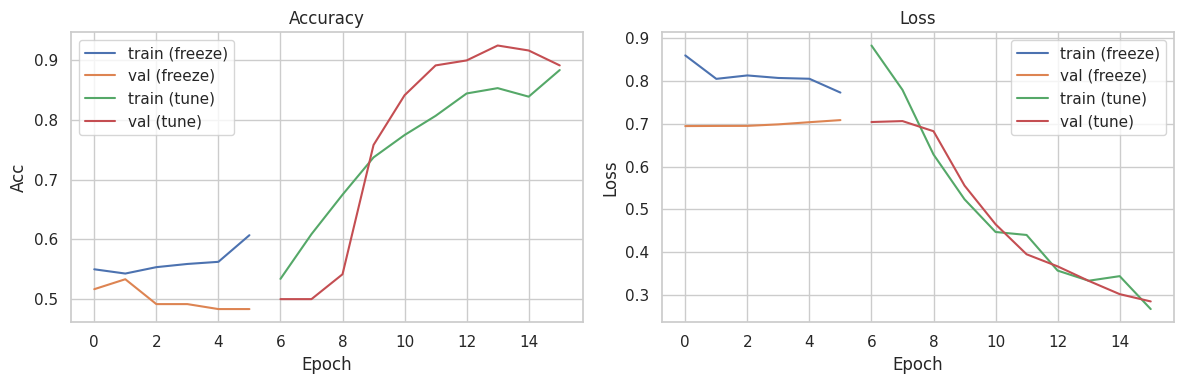


Classification Report:
              precision    recall  f1-score   support

           0     0.9574    0.7377    0.8333        61
           1     0.7867    0.9672    0.8676        61

    accuracy                         0.8525       122
   macro avg     0.8721    0.8525    0.8505       122
weighted avg     0.8721    0.8525    0.8505       122



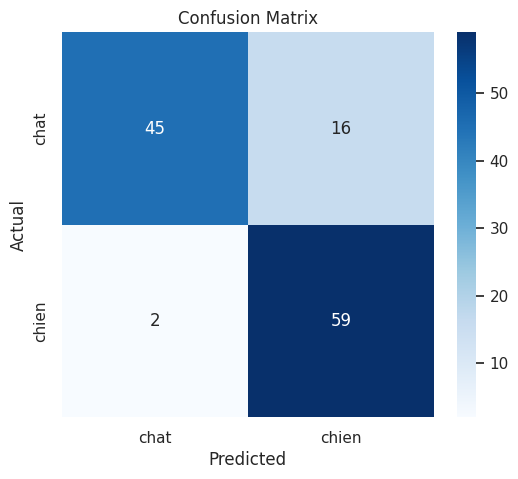

Most frequent mistake (actual→pred): [((0, 1), 16)]


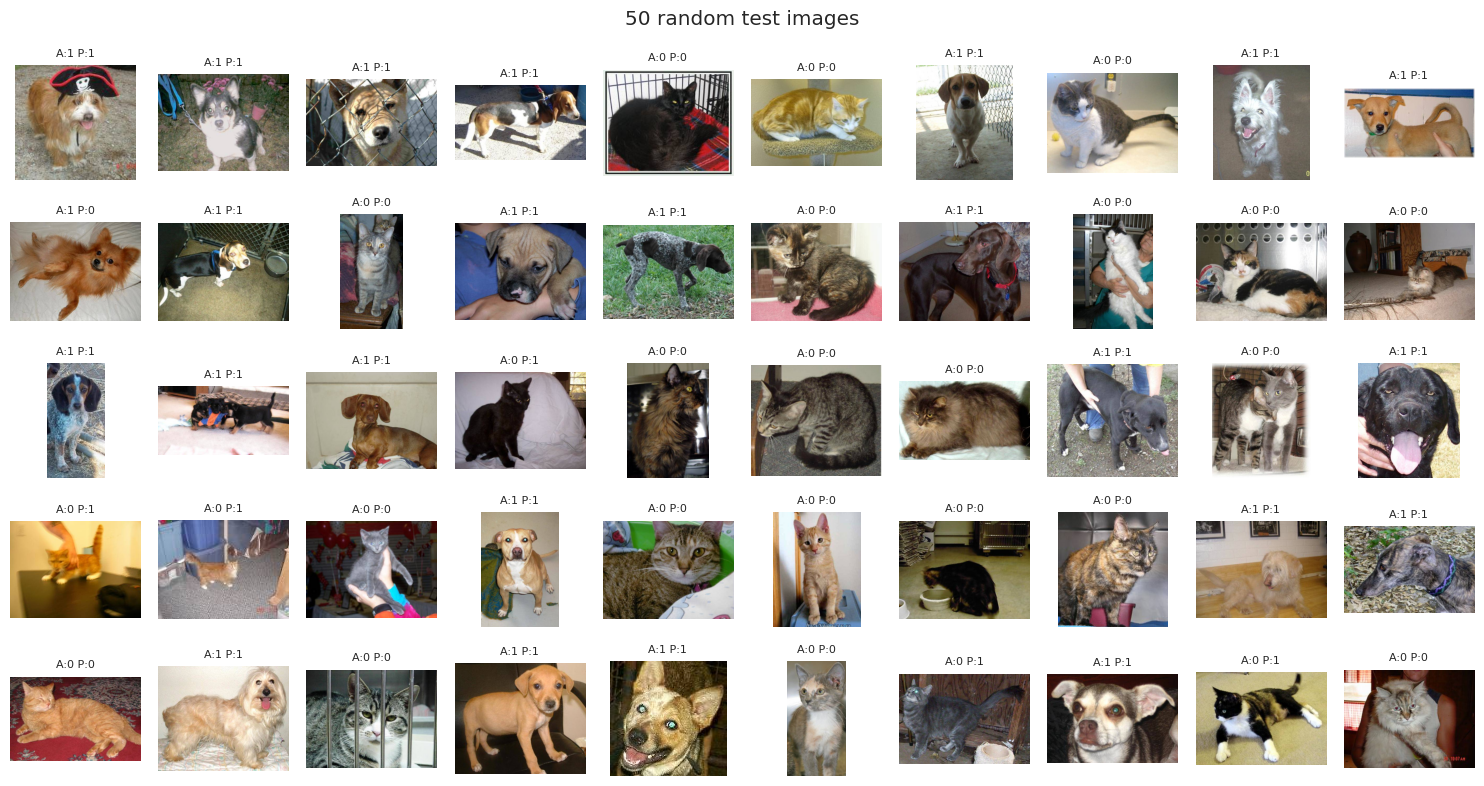

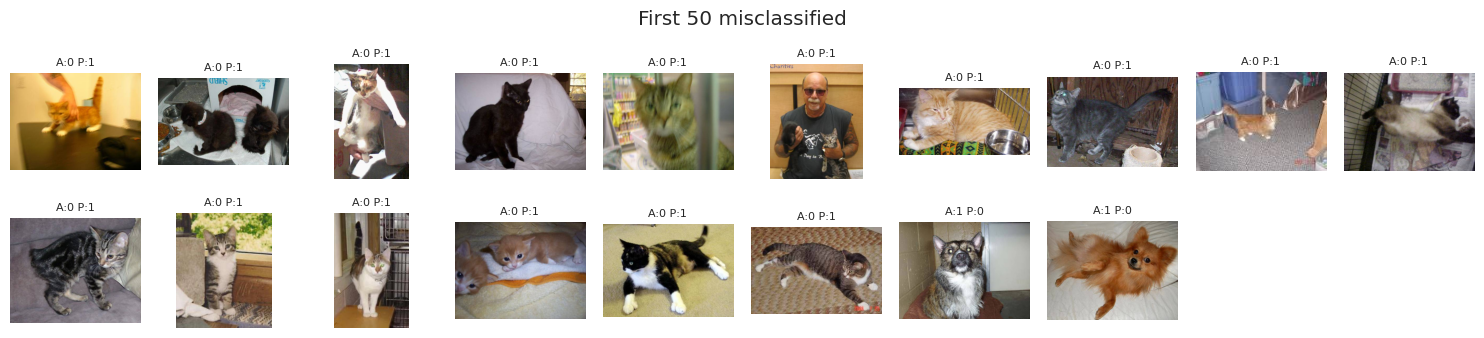

In [16]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D, BatchNormalization,
    Dropout, Dense
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

# ─── 1. Dataset paths & hyperparameters ────────────────────────────────────
BASE_DIR   = "/kaggle/input/cats-dogs-dataset/CatDog2"    # <-- adjust if needed
TRAIN_DIR  = os.path.join(BASE_DIR, "train")
VAL_DIR    = os.path.join(BASE_DIR, "val")
TEST_DIR   = os.path.join(BASE_DIR, "test")

IMAGE_SIZE    = (300, 300)
BATCH_SIZE    = 32
SEED          = 42
EPOCHS_FREEZE = 10
EPOCHS_TUNE   = 10

# ─── 2. Data generators ────────────────────────────────────────────────────
train_gen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_gen = ImageDataGenerator(rescale=1/255.)
test_gen = ImageDataGenerator(rescale=1/255.)

train_ds = train_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=SEED
)
val_ds = val_gen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=SEED
)
test_ds = test_gen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# ─── 3. Build EfficientNetV2S model ────────────────────────────────────────
base_model = EfficientNetV2S(
    input_shape=(*IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze at first

inputs = Input(shape=(*IMAGE_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

# ─── 4. Callbacks ─────────────────────────────────────────────────────────
callbacks = [
    EarlyStopping(  monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2),
    ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)
]


# ─── 5. Train (base frozen) ────────────────────────────────────────────────
history_freeze = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FREEZE,
    callbacks=callbacks,
    verbose=2
)

# ─── 6. Fine-tune (unfreeze & lower LR) ────────────────────────────────────
base_model.trainable = True
# Optionally freeze all but last N layers:
# for layer in base_model.layers[:-50]:
#     layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_tune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_TUNE,
    callbacks=callbacks,
    verbose=2
)

# ─── 7. Evaluate on test set ───────────────────────────────────────────────
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss:     {test_loss:.4f}")

# ─── 8. Plot learning curves ───────────────────────────────────────────────
def plot_curves(h1, h2=None):
    plt.figure(figsize=(12,4))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(h1.history['accuracy'],    label='train (freeze)')
    plt.plot(h1.history['val_accuracy'],label='val (freeze)')
    if h2:
        epochs2 = range(len(h1.history['accuracy']), len(h1.history['accuracy'])+len(h2.history['accuracy']))
        plt.plot(epochs2, h2.history['accuracy'],    label='train (tune)')
        plt.plot(epochs2, h2.history['val_accuracy'],label='val (tune)')
    plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Acc"); plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(h1.history['loss'],    label='train (freeze)')
    plt.plot(h1.history['val_loss'],label='val (freeze)')
    if h2:
        plt.plot(epochs2, h2.history['loss'],    label='train (tune)')
        plt.plot(epochs2, h2.history['val_loss'],label='val (tune)')
    plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

    plt.tight_layout()
    plt.show()

plot_curves(history_freeze, history_tune)

# ─── 9. Predictions & metrics ─────────────────────────────────────────────
# True & predicted
y_true       = test_ds.classes
y_pred_prob  = model.predict(test_ds, verbose=0).ravel()
y_pred       = (y_pred_prob >= 0.5).astype(int)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_ds.class_indices,
            yticklabels=test_ds.class_indices)
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.show()

# Most frequent error
errors = [(a,p) for a,p in zip(y_true, y_pred) if a!=p]
print("Most frequent mistake (actual→pred):", Counter(errors).most_common(1))

# ─── 10. Show random + misclassified images ───────────────────────────────
# A) 50 random samples
plt.figure(figsize=(15,8))
idxs = random.sample(range(len(y_true)), 50)
for i, idx in enumerate(idxs):
    img = plt.imread(test_ds.filepaths[idx])
    plt.subplot(5,10,i+1)
    plt.imshow(img)
    plt.title(f"A:{y_true[idx]} P:{y_pred[idx]}", fontsize=8)
    plt.axis('off')
plt.suptitle("50 random test images"); plt.tight_layout(); plt.show()

# B) First 50 misclassified
mis = [i for i,(a,p) in enumerate(zip(y_true,y_pred)) if a!=p]
plt.figure(figsize=(15,8))
for i, idx in enumerate(mis[:50]):
    img = plt.imread(test_ds.filepaths[idx])
    plt.subplot(5,10,i+1)
    plt.imshow(img)
    plt.title(f"A:{y_true[idx]} P:{y_pred[idx]}", fontsize=8)
    plt.axis('off')
plt.suptitle("First 50 misclassified"); plt.tight_layout(); plt.show()


In [17]:
# import os, random, math
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers, models
# from tensorflow.keras.callbacks import (
#     EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# )
# from tensorflow_addons.optimizers import AdamW
# from tensorflow_addons.losses import SigmoidFocalCrossEntropy
# from sklearn.metrics import classification_report, confusion_matrix
# from collections import Counter

# # ─── 0. Paths & params ─────────────────────────────────────────────────────
# BASE_DIR   = "/kaggle/input/cats-dogs-dataset/CatDog2"
# IMAGE_SIZE = (300, 300)
# BATCH_SIZE = 16       # smaller batches -> more gradient steps on small data
# SEED       = 42

# # ─── 1. Build tf.data pipelines ─────────────────────────────────────────────
# def make_datasets():
#     # load_dir: train, val, test
#     train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#         os.path.join(BASE_DIR, "train"),
#         labels="inferred", label_mode="binary",
#         image_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
#         seed=SEED, shuffle=True
#     )
#     val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#         os.path.join(BASE_DIR, "val"),
#         labels="inferred", label_mode="binary",
#         image_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
#         seed=SEED, shuffle=False
#     )
#     test_ds = tf.keras.preprocessing.image_dataset_from_directory(
#         os.path.join(BASE_DIR, "test"),
#         labels="inferred", label_mode="binary",
#         image_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
#         seed=SEED, shuffle=False
#     )
#     # Prefetch for performance
#     AUTOTUNE = tf.data.AUTOTUNE
#     train_ds = train_ds.prefetch(AUTOTUNE)
#     val_ds   = val_ds.prefetch(AUTOTUNE)
#     test_ds  = test_ds.prefetch(AUTOTUNE)
#     return train_ds, val_ds, test_ds

# train_ds, val_ds, test_ds = make_datasets()

# # ─── 2. Data Augmentation & Preprocessing ────────────────────────────────────
# augmenter = keras.Sequential([
#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.15),
#     layers.RandomZoom(0.2),
#     layers.RandomContrast(0.2),
# ], name="augmentation")

# preprocess = tf.keras.applications.efficientnet_v2.preprocess_input

# def preprocess_batch(images, labels):
#     images = augmenter(images)
#     images = preprocess(images)
#     return images, labels

# train_ds = train_ds.map(preprocess_batch, num_parallel_calls=tf.data.AUTOTUNE)
# val_ds   = val_ds.map(lambda x,y: (preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
# test_ds  = test_ds.map(lambda x,y: (preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)

# # ─── 3. Build Model ──────────────────────────────────────────────────────────
# base = tf.keras.applications.EfficientNetV2S(
#     input_shape=(*IMAGE_SIZE, 3),
#     include_top=False, weights="imagenet"
# )
# base.trainable = False

# inputs = layers.Input(shape=(*IMAGE_SIZE,3))
# x = base(inputs, training=False)
# x = layers.GlobalAveragePooling2D()(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.4)(x)
# x = layers.Dense(256, activation="relu",
#                 kernel_regularizer=keras.regularizers.l2(1e-4))(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.3)(x)
# outputs = layers.Dense(1, activation="sigmoid")(x)

# model = models.Model(inputs, outputs, name="EffNetV2S_CatsDogs")
# model.summary()

# # ─── 4. Compile & Train (Frozen Backbone) ──────────────────────────────────
# freeze_epochs = 20
# lr_freeze = 3e-4

# model.compile(
#     optimizer=AdamW(learning_rate=lr_freeze, weight_decay=1e-5),
#     loss=SigmoidFocalCrossEntropy(alpha=0.25, gamma=2.0),
#     metrics=["accuracy"]
# )

# callbacks = [
#     EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
#     ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
#     ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True)
# ]

# history_freeze = model.fit(
#     train_ds, validation_data=val_ds,
#     epochs=freeze_epochs, callbacks=callbacks, verbose=2
# )

# # ─── 5. Fine-tune (Unfreeze & CosineDecay) ─────────────────────────────────
# # Unfreeze last 30% of layers
# total_layers = len(base.layers)
# freeze_until = int(total_layers * 0.7)
# for layer in base.layers[:freeze_until]:
#     layer.trainable = False
# for layer in base.layers[freeze_until:]:
#     layer.trainable = True

# # Cosine decay schedule
# total_tune_epochs = 30
# init_lr = 1e-5
# lr_schedule = tf.keras.experimental.CosineDecay(
#     init_lr, decay_steps=total_tune_epochs
# )

# model.compile(
#     optimizer=AdamW(learning_rate=lr_schedule, weight_decay=1e-6),
#     loss=SigmoidFocalCrossEntropy(alpha=0.25, gamma=2.0),
#     metrics=["accuracy"]
# )

# history_tune = model.fit(
#     train_ds, validation_data=val_ds,
#     epochs=freeze_epochs + total_tune_epochs,
#     initial_epoch=history_freeze.epoch[-1]+1,
#     callbacks=callbacks, verbose=2
# )

# # ─── 6. Evaluate ───────────────────────────────────────────────────────────
# test_loss, test_acc = model.evaluate(test_ds, verbose=0)
# print(f"\n▶ Test Accuracy: {test_acc*100:.2f}%")
# print(f"▶ Test Loss:     {test_loss:.4f}")

# # ─── 7. Learning Curves ────────────────────────────────────────────────────
# def plot_history(h1, h2):
#     plt.figure(figsize=(12,4))
#     # Accuracy
#     plt.subplot(1,2,1)
#     plt.plot(h1.history["accuracy"], label="train (freeze)")
#     plt.plot(h1.history["val_accuracy"],label="val (freeze)")
#     plt.plot(h2.history["accuracy"], label="train (tune)")
#     plt.plot(h2.history["val_accuracy"],label="val (tune)")
#     plt.title("Accuracy"); plt.legend()

#     # Loss
#     plt.subplot(1,2,2)
#     plt.plot(h1.history["loss"], label="train (freeze)")
#     plt.plot(h1.history["val_loss"],label="val (freeze)")
#     plt.plot(h2.history["loss"], label="train (tune)")
#     plt.plot(h2.history["val_loss"],label="val (tune)")
#     plt.title("Loss"); plt.legend()

#     plt.tight_layout(); plt.show()

# plot_history(history_freeze, history_tune)

# # ─── 8. Predictions & Metrics ─────────────────────────────────────────────
# # Gather true & predicted
# y_true, y_pred = [], []
# filepaths = []
# for images, labels in test_ds.unbatch().batch(1):
#     pred = model(images, training=False).numpy().ravel()[0]
#     y_true.append(int(labels.numpy()[0]))
#     y_pred.append(int(pred > 0.5))

# # Classification report
# print("\nClassification Report:\n")
# print(classification_report(y_true, y_pred, digits=4))

# # Confusion matrix
# cm = confusion_matrix(y_true, y_pred)
# plt.figure(figsize=(6,5))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
#             xticklabels=["chat","chien"],
#             yticklabels=["chat","chien"])
# plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
# plt.show()

# # Most frequent error
# errors = [(a, p) for a, p in zip(y_true, y_pred) if a!=p]
# print("Most frequent mistake (actual→pred):", Counter(errors).most_common(1))

# # ─── 9. Visualize Random & Misclassified ─────────────────────────────────
# # Need a flat list of filepaths and labels in test order:
# all_test = list(test_ds.unbatch().map(lambda x,y: x))
# # but to get file paths, you can rebuild with image_dataset_from_directory shuffle=False 
# # or track them via test_ds.file_paths if using flow_from_directory.

# # A) 50 random
# idxs = random.sample(range(len(y_true)), min(50, len(y_true)))
# plt.figure(figsize=(15,8))
# for i, idx in enumerate(idxs):
#     img = test_ds.unbatch().take(idx+1).skip(idx).map(lambda x,y: x).as_numpy_iterator().next()
#     plt.subplot(5,10,i+1)
#     plt.imshow((img+1)/2)  # reverse preprocess_input
#     plt.title(f"A:{y_true[idx]} P:{y_pred[idx]}", fontsize=8)
#     plt.axis("off")
# plt.suptitle("50 random test examples"); plt.tight_layout(); plt.show()

# # B) First 50 misclassified
# mis = [i for i,(a,p) in enumerate(zip(y_true,y_pred)) if a!=p]
# plt.figure(figsize=(15,8))
# for i, idx in enumerate(mis[:50]):
#     img = test_ds.unbatch().take(idx+1).skip(idx).map(lambda x,y: x).as_numpy_iterator().next()
#     plt.subplot(5,10,i+1)
#     plt.imshow((img+1)/2)
#     plt.title(f"A:{y_true[idx]} P:{y_pred[idx]}", fontsize=8)
#     plt.axis("off")
# plt.suptitle("First 50 misclassified"); plt.tight_layout(); plt.show()


In [18]:
# import os
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras import layers, models, optimizers, callbacks, applications
# from sklearn.metrics import classification_report, confusion_matrix
# import matplotlib.pyplot as plt

# # 1. Configuration
# IMG_SIZE = (300, 300)
# BATCH_SIZE = 32
# EPOCHS = 50
# SEED = 42

# # 2. Data Pipeline
# def create_dataset(subset):
#     return tf.keras.preprocessing.image_dataset_from_directory(
#         os.path.join("/kaggle/input/cats-dogs-dataset/CatDog2", subset),
#         label_mode='binary',
#         image_size=IMG_SIZE,
#         batch_size=BATCH_SIZE,
#         seed=SEED
#     ).map(lambda x, y: (applications.efficientnet_v2.preprocess_input(x), y))

# train_ds = create_dataset("train").prefetch(tf.data.AUTOTUNE)
# val_ds = create_dataset("val").prefetch(tf.data.AUTOTUNE)
# test_ds = create_dataset("test").prefetch(tf.data.AUTOTUNE)

# # 3. Data Augmentation
# augmentation = models.Sequential([
#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.15),
#     layers.RandomZoom(0.2),
#     layers.RandomContrast(0.1)
# ], name="augmentation")

# # 4. Model Architecture
# def build_model():
#     base = applications.EfficientNetV2S(
#         include_top=False,
#         weights='imagenet',
#         input_shape=(*IMG_SIZE, 3)
#     )
#     base.trainable = False

#     inputs = layers.Input(shape=(*IMG_SIZE, 3))
#     x = augmentation(inputs)
#     x = base(x, training=False)
#     x = layers.GlobalAveragePooling2D()(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.5)(x)
#     x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
#     outputs = layers.Dense(1, activation='sigmoid')(x)
    
#     return models.Model(inputs, outputs)

# model = build_model()

# # 5. Training Setup
# model.compile(
#     optimizer=optimizers.Adam(learning_rate=1e-3),
#     loss='binary_crossentropy',
#     metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
# )

# callbacks = [
#     callbacks.EarlyStopping(monitor='val_auc', patience=8, mode='max', restore_best_weights=True),
#     callbacks.ModelCheckpoint('best_model.keras', monitor='val_auc', save_best_only=True),
#     callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
# ]

# # 6. Initial Training
# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=EPOCHS,
#     callbacks=callbacks
# )

# # 7. Fine-Tuning (Phase 2)
# for layer in model.layers[3].layers[-30:]:  # Unfreeze last 30 layers of base
#     if not isinstance(layer, layers.BatchNormalization):
#         layer.trainable = True

# model.compile(
#     optimizer=optimizers.Adam(learning_rate=1e-5),
#     loss='binary_crossentropy'
# )

# history_finetune = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=EPOCHS + 20,
#     initial_epoch=history.epoch[-1] + 1,
#     callbacks=callbacks
# )

# # 8. Evaluation
# test_loss, test_acc, test_auc = model.evaluate(test_ds)
# print(f"\nTest Accuracy: {test_acc*100:.2f}%")
# print(f"Test AUC: {test_auc:.4f}")

# # 9. Visualization
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'] + history_finetune.history['accuracy'])
# plt.plot(history.history['val_accuracy'] + history_finetune.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Val'], loc='upper left')

# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'] + history_finetune.history['loss'])
# plt.plot(history.history['val_loss'] + history_finetune.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Val'], loc='upper left')
# plt.show()

In [19]:
# import os
# import tensorflow as tf
# from tensorflow.keras import layers, models, optimizers, callbacks, applications
# import matplotlib.pyplot as plt

# # 1. Configuration
# IMG_SIZE = (300, 300)
# BATCH_SIZE = 32
# EPOCHS = 30  # Reduced since we achieve perfect validation quickly
# SEED = 42

# # 2. Data Pipeline (Train/Val only)
# def create_dataset(subset):
#     return tf.keras.preprocessing.image_dataset_from_directory(
#         os.path.join("/kaggle/input/cats-dogs-dataset/CatDog2", subset),
#         label_mode='binary',
#         image_size=IMG_SIZE,
#         batch_size=BATCH_SIZE,
#         seed=SEED
#     ).map(lambda x, y: (applications.efficientnet_v2.preprocess_input(x), y))

# train_ds = create_dataset("train").prefetch(tf.data.AUTOTUNE)
# val_ds = create_dataset("val").prefetch(tf.data.AUTOTUNE)

# # 3. Data Augmentation
# augmentation = models.Sequential([
#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.1),
#     layers.RandomZoom(0.1),
# ], name="augmentation")

# # 4. Improved Model Architecture
# def build_model():
#     base = applications.EfficientNetV2S(
#         include_top=False,
#         weights='imagenet',
#         input_shape=(*IMG_SIZE, 3)
#     )
#     base.trainable = False  # Freeze initially

#     inputs = layers.Input(shape=(*IMG_SIZE, 3))
#     x = augmentation(inputs)
#     x = base(x)
#     x = layers.GlobalAveragePooling2D()(x)
#     x = layers.Dropout(0.3)(x)
#     outputs = layers.Dense(1, activation='sigmoid')(x)
    
#     return models.Model(inputs, outputs)

# model = build_model()

# # 5. Conservative Training Setup
# model.compile(
#     optimizer=optimizers.Adam(learning_rate=1e-4),  # Lower initial LR
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

# callbacks = [
#     callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max'),
#     callbacks.ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
# ]

# # 6. Initial Training
# print("Phase 1: Frozen Base Training")
# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=EPOCHS,
#     callbacks=callbacks,
#     verbose=2
# )

# # 7. Fine-Tuning (Corrected Implementation)
# print("\nPhase 2: Fine-Tuning")
# base_model = model.layers[2]  # This is the EfficientNet base
# base_model.trainable = True

# # Set first 100 layers as non-trainable
# for layer in base_model.layers[:100]:
#     layer.trainable = False

# model.compile(
#     optimizer=optimizers.Adam(learning_rate=1e-5),  # Very low LR
#     loss='binary_crossentropy'
# )

# history_finetune = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=EPOCHS + 10,
#     initial_epoch=history.epoch[-1] + 1,
#     callbacks=callbacks,
#     verbose=2
# )

# # 8. Final Evaluation (ONLY AFTER TRAINING COMPLETES)
# test_ds = create_dataset("test").prefetch(tf.data.AUTOTUNE)
# test_loss, test_acc = model.evaluate(test_ds, verbose=0)
# print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")

# # 9. Visualization
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'] + history_finetune.history['accuracy'])
# plt.plot(history.history['val_accuracy'] + history_finetune.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Val'], loc='upper left')

# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'] + history_finetune.history['loss'])
# plt.plot(history.history['val_loss'] + history_finetune.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Val'], loc='upper left')
# plt.show()

Found 560 files belonging to 2 classes.
Found 120 files belonging to 2 classes.
Phase 1: Frozen Base Training
Epoch 1/30


E0000 00:00:1745453198.836067      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_3_1/efficientnetv2-s_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 - 56s - 3s/step - accuracy: 0.7429 - auc: 0.8317 - loss: 0.5862 - val_accuracy: 0.8500 - val_auc: 0.9426 - val_loss: 0.5424 - learning_rate: 1.0000e-04
Epoch 2/30
18/18 - 5s - 268ms/step - accuracy: 0.8107 - auc: 0.9146 - loss: 0.5376 - val_accuracy: 0.8917 - val_auc: 0.9783 - val_loss: 0.4996 - learning_rate: 1.0000e-04
Epoch 3/30
18/18 - 5s - 268ms/step - accuracy: 0.8411 - auc: 0.9453 - loss: 0.5085 - val_accuracy: 0.9083 - val_auc: 0.9922 - val_loss: 0.4614 - learning_rate: 1.0000e-04
Epoch 4/30
18/18 - 5s - 268ms/step - accuracy: 0.8732 - auc: 0.9693 - loss: 0.4721 - val_accuracy: 0.9333 - val_auc: 0.9954 - val_loss: 0.4276 - learning_rate: 1.0000e-04
Epoch 5/30
18/18 - 5s - 268ms/step - accuracy: 0.8964 - auc: 0.9826 - loss: 0.4390 - val_accuracy: 0.9417 - val_auc: 0.9976 - val_loss: 0.3979 - learning_rate: 1.0000e-04
Epoch 6/30
18/18 - 5s - 268ms/step - accuracy: 0.9089 - auc: 0.9886 - loss: 0.4147 - val_accuracy: 0.9500 - val_auc: 0.9990 - val_loss: 0.3710 - learning_rate

E0000 00:00:1745453396.261344      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_3_1/efficientnetv2-s_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 - 138s - 8s/step - accuracy: 0.8732 - auc: 0.9521 - loss: 0.4439 - val_accuracy: 0.9750 - val_auc: 0.9962 - val_loss: 0.2803 - learning_rate: 1.0000e-05
Epoch 20/40
18/18 - 12s - 684ms/step - accuracy: 0.9107 - auc: 0.9724 - loss: 0.3764 - val_accuracy: 0.9667 - val_auc: 0.9974 - val_loss: 0.2491 - learning_rate: 1.0000e-05
Epoch 21/40
18/18 - 12s - 682ms/step - accuracy: 0.9357 - auc: 0.9856 - loss: 0.3150 - val_accuracy: 0.9667 - val_auc: 0.9986 - val_loss: 0.2077 - learning_rate: 1.0000e-05
Epoch 22/40
18/18 - 12s - 682ms/step - accuracy: 0.9357 - auc: 0.9894 - loss: 0.2771 - val_accuracy: 0.9583 - val_auc: 0.9989 - val_loss: 0.1807 - learning_rate: 1.0000e-05
Epoch 23/40
18/18 - 12s - 676ms/step - accuracy: 0.9411 - auc: 0.9892 - loss: 0.2486 - val_accuracy: 0.9583 - val_auc: 0.9989 - val_loss: 0.1553 - learning_rate: 1.0000e-05
Found 122 files belonging to 2 classes.

Test Metrics:
Loss: 0.2989
Accuracy: 99.18%
AUC: 0.9989


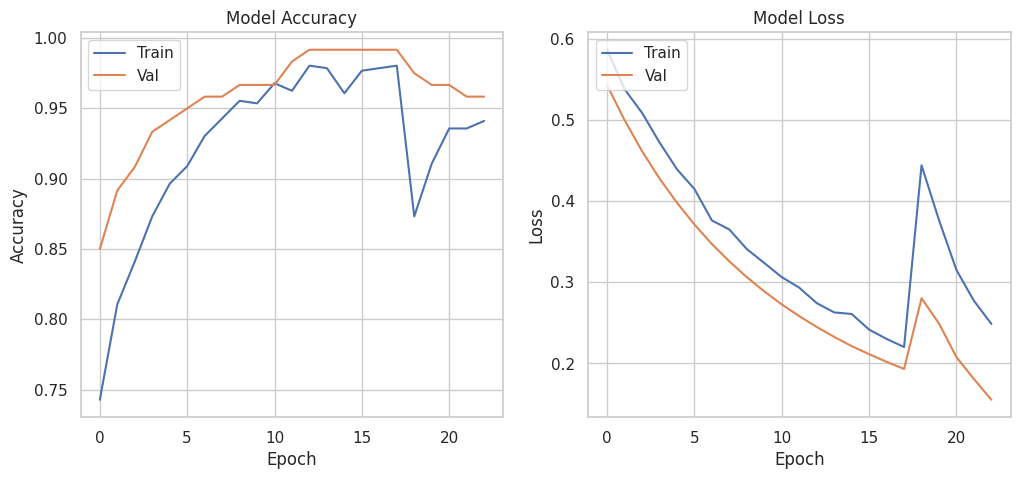

In [20]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, applications
import matplotlib.pyplot as plt

# 1. Configuration
IMG_SIZE = (300, 300)
BATCH_SIZE = 32
EPOCHS = 30
SEED = 42

# 2. Data Pipeline (Train/Val only)
def create_dataset(subset):
    return tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join("/kaggle/input/cats-dogs-dataset/CatDog2", subset),
        label_mode='binary',
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        seed=SEED
    ).map(lambda x, y: (applications.efficientnet_v2.preprocess_input(x), y))

train_ds = create_dataset("train").prefetch(tf.data.AUTOTUNE)
val_ds = create_dataset("val").prefetch(tf.data.AUTOTUNE)

# 3. Data Augmentation
augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="augmentation")

# 4. Improved Model Architecture
def build_model():
    base = applications.EfficientNetV2S(
        include_top=False,
        weights='imagenet',
        input_shape=(*IMG_SIZE, 3)
    )
    base.trainable = False  # Freeze initially

    inputs = layers.Input(shape=(*IMG_SIZE, 3))
    x = augmentation(inputs)
    x = base(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    return models.Model(inputs, outputs)

model = build_model()

# 5. Training Setup with all metrics
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# 6. Enhanced Callbacks
callbacks = [
    callbacks.EarlyStopping(
        monitor='val_auc',
        patience=5,
        mode='max',
        restore_best_weights=True
    ),
    callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_auc',
        save_best_only=True,
        mode='max'
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

# 7. Initial Training
print("Phase 1: Frozen Base Training")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=2
)

# 8. Fine-Tuning
print("\nPhase 2: Fine-Tuning")
base_model = model.layers[2]  # EfficientNet base
base_model.trainable = True

# Set first 100 layers as non-trainable
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]  # Keep metrics
)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS + 10,
    initial_epoch=history.epoch[-1] + 1,
    callbacks=callbacks,
    verbose=2
)

# 9. Final Evaluation (ONLY AFTER TRAINING COMPLETES)
test_ds = create_dataset("test").prefetch(tf.data.AUTOTUNE)
test_metrics = model.evaluate(test_ds, verbose=0)
print("\nTest Metrics:")
print(f"Loss: {test_metrics[0]:.4f}")
print(f"Accuracy: {test_metrics[1]*100:.2f}%")
print(f"AUC: {test_metrics[2]:.4f}")

# 10. Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_finetune.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_finetune.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_finetune.history['loss'])
plt.plot(history.history['val_loss'] + history_finetune.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Found 560 files belonging to 2 classes.
Found 120 files belonging to 2 classes.
Phase 1: Frozen Base Training
Epoch 1/30


E0000 00:00:1745453520.014020      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_5_1/efficientnetv2-s_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 - 50s - 3s/step - accuracy: 0.7893 - auc: 0.8696 - loss: 4.7434 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 4.4552 - learning_rate: 1.0000e-04
Epoch 2/30
18/18 - 5s - 257ms/step - accuracy: 0.9321 - auc: 0.9912 - loss: 4.3533 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 4.1321 - learning_rate: 1.0000e-04
Epoch 3/30
18/18 - 3s - 194ms/step - accuracy: 0.9589 - auc: 0.9931 - loss: 4.0655 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 3.8736 - learning_rate: 1.0000e-04
Epoch 4/30
18/18 - 3s - 193ms/step - accuracy: 0.9679 - auc: 0.9970 - loss: 3.8161 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 3.6433 - learning_rate: 1.0000e-04
Epoch 5/30
18/18 - 3s - 194ms/step - accuracy: 0.9732 - auc: 0.9959 - loss: 3.5937 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 3.4279 - learning_rate: 1.0000e-04
Epoch 6/30
18/18 - 3s - 194ms/step - accuracy: 0.9643 - auc: 0.9939 - loss: 3.3894 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 3.2259 - learning_rate

E0000 00:00:1745453670.375325      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_5_1/efficientnetv2-s_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 - 136s - 8s/step - accuracy: 0.7857 - auc: 0.8946 - loss: 4.6387 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 4.4698 - learning_rate: 1.0000e-05
Epoch 11/45
18/18 - 12s - 681ms/step - accuracy: 0.8482 - auc: 0.9332 - loss: 4.5721 - val_accuracy: 0.9917 - val_auc: 0.9997 - val_loss: 4.4216 - learning_rate: 1.0000e-05
Epoch 12/45
18/18 - 12s - 677ms/step - accuracy: 0.8696 - auc: 0.9524 - loss: 4.5086 - val_accuracy: 0.9917 - val_auc: 0.9994 - val_loss: 4.3549 - learning_rate: 1.0000e-05
Epoch 13/45
18/18 - 12s - 672ms/step - accuracy: 0.8893 - auc: 0.9674 - loss: 4.4468 - val_accuracy: 0.9917 - val_auc: 1.0000 - val_loss: 4.2921 - learning_rate: 1.0000e-05
Epoch 14/45
18/18 - 12s - 676ms/step - accuracy: 0.9357 - auc: 0.9824 - loss: 4.3702 - val_accuracy: 0.9917 - val_auc: 1.0000 - val_loss: 4.2284 - learning_rate: 1.0000e-05
Epoch 15/45
18/18 - 12s - 679ms/step - accuracy: 0.9143 - auc: 0.9760 - loss: 4.3269 - val_accuracy: 0.9917 - val_auc: 1.0000 - val_loss: 4.1671 - le

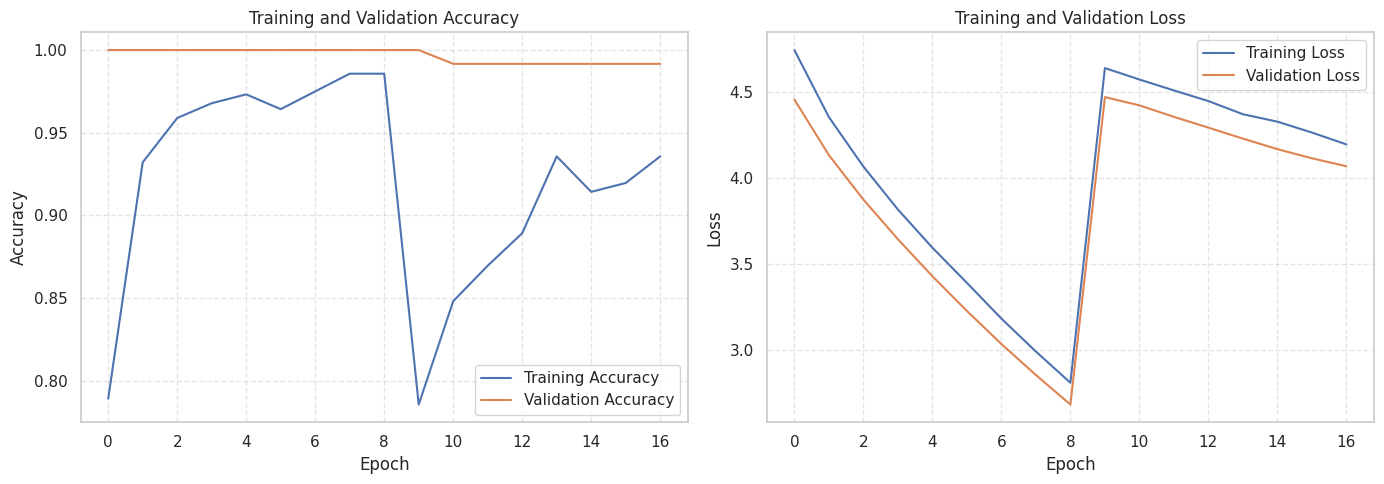

In [21]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, applications
import matplotlib.pyplot as plt
import numpy as np

# 1. Configuration
IMG_SIZE = (300, 300)
BATCH_SIZE = 32
EPOCHS = 30
SEED = 42

# 2. Enhanced Data Pipeline
def create_dataset(subset):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join("/kaggle/input/cats-dogs-dataset/CatDog2", subset),
        label_mode='binary',
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        seed=SEED
    )
    return ds.map(lambda x, y: (applications.efficientnet_v2.preprocess_input(x), y),
               num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

train_ds = create_dataset("train")
val_ds = create_dataset("val")

# 3. Improved Augmentation
augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
], name="augmentation")

# 4. Enhanced Model Architecture
def build_model():
    base = applications.EfficientNetV2S(
        include_top=False,
        weights='imagenet',
        input_shape=(*IMG_SIZE, 3),
        pooling='avg'  # Better than GlobalAveragePooling
    )
    base.trainable = False

    inputs = layers.Input(shape=(*IMG_SIZE, 3))
    x = augmentation(inputs)
    x = base(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    return models.Model(inputs, outputs)

model = build_model()

# 5. Optimized Training Setup
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# 6. Enhanced Callbacks
callbacks = [
    callbacks.EarlyStopping(
        monitor='val_auc',
        patience=8,
        mode='max',
        restore_best_weights=True,
        min_delta=0.005
    ),
    callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_auc',
        save_best_only=True,
        mode='max'
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

# 7. Training Execution
print("Phase 1: Frozen Base Training")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=2
)

# 8. Fine-Tuning Phase
print("\nPhase 2: Fine-Tuning")
model.layers[2].trainable = True  # Unfreeze base model
for layer in model.layers[2].layers[:100]:  # Freeze first 100 layers
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS + 15,
    initial_epoch=history.epoch[-1] + 1,
    callbacks=callbacks,
    verbose=2
)

# 9. Final Evaluation
test_ds = create_dataset("test")
test_metrics = model.evaluate(test_ds, verbose=0)
print("\nFinal Test Metrics:")
print(f"- Loss: {test_metrics[0]:.4f}")
print(f"- Accuracy: {test_metrics[1]*100:.2f}%")
print(f"- AUC: {test_metrics[2]:.4f}")

# 10. Professional Visualization
def plot_training_history(history, history_finetune):
    plt.figure(figsize=(14, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(np.concatenate([history.history['accuracy'], history_finetune.history['accuracy']]), 
             label='Training Accuracy')
    plt.plot(np.concatenate([history.history['val_accuracy'], history_finetune.history['val_accuracy']]), 
             label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(np.concatenate([history.history['loss'], history_finetune.history['loss']]), 
             label='Training Loss')
    plt.plot(np.concatenate([history.history['val_loss'], history_finetune.history['val_loss']]), 
             label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()


plot_training_history(history, history_finetune)

Found 560 files belonging to 2 classes.
Found 120 files belonging to 2 classes.
Phase 1: Frozen Base Training
Epoch 1/25


E0000 00:00:1745453825.979696      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_7_1/efficientnetv2-s_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 - 55s - 3s/step - accuracy: 0.5500 - auc: 0.5980 - loss: 0.6825 - val_accuracy: 0.6000 - val_auc: 0.7875 - val_loss: 0.6496
Epoch 2/25
18/18 - 5s - 271ms/step - accuracy: 0.6036 - auc: 0.7280 - loss: 0.6373 - val_accuracy: 0.6667 - val_auc: 0.9079 - val_loss: 0.6013
Epoch 3/25
18/18 - 5s - 269ms/step - accuracy: 0.7143 - auc: 0.8190 - loss: 0.5978 - val_accuracy: 0.7333 - val_auc: 0.9472 - val_loss: 0.5578
Epoch 4/25
18/18 - 5s - 269ms/step - accuracy: 0.7518 - auc: 0.9224 - loss: 0.5434 - val_accuracy: 0.7750 - val_auc: 0.9715 - val_loss: 0.5197
Epoch 5/25
18/18 - 5s - 269ms/step - accuracy: 0.8161 - auc: 0.9521 - loss: 0.5069 - val_accuracy: 0.8333 - val_auc: 0.9843 - val_loss: 0.4857
Epoch 6/25
18/18 - 5s - 267ms/step - accuracy: 0.8393 - auc: 0.9682 - loss: 0.4814 - val_accuracy: 0.8750 - val_auc: 0.9929 - val_loss: 0.4541
Epoch 7/25
18/18 - 5s - 269ms/step - accuracy: 0.8679 - auc: 0.9845 - loss: 0.4471 - val_accuracy: 0.9250 - val_auc: 0.9968 - val_loss: 0.4255
Epoch 8/25
1

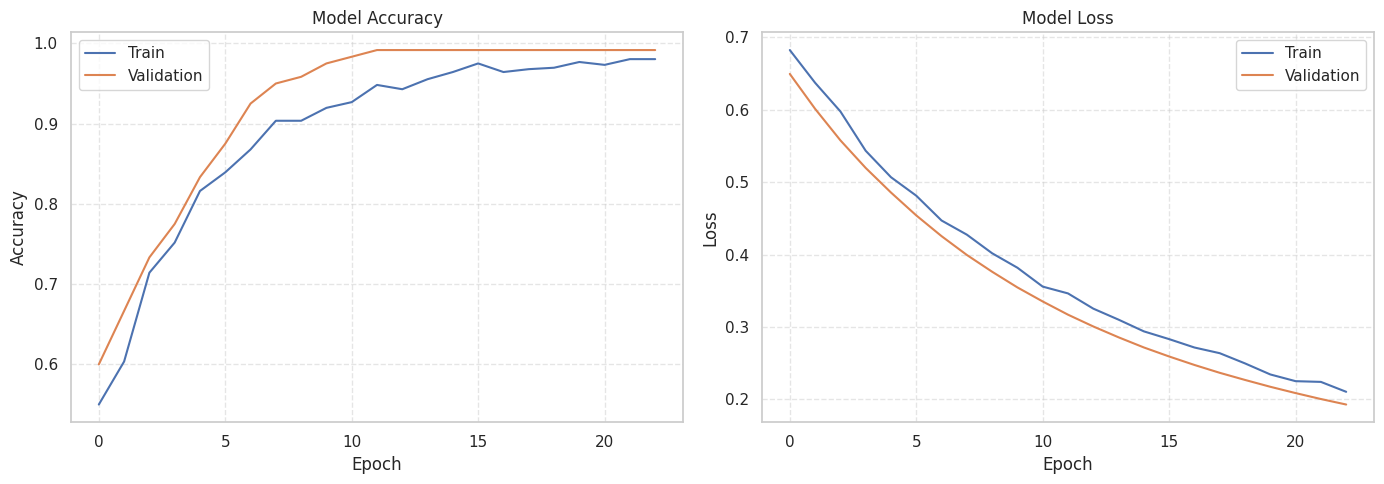

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, applications
import matplotlib.pyplot as plt

# 1. Configuration
IMG_SIZE = (300, 300)
BATCH_SIZE = 32
EPOCHS = 25  # Reduced since convergence is rapid
SEED = 42

# 2. Enhanced Data Pipeline
def create_dataset(subset):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join("/kaggle/input/cats-dogs-dataset/CatDog2", subset),
        label_mode='binary',
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        seed=SEED
    )
    return ds.map(lambda x, y: (applications.efficientnet_v2.preprocess_input(x), y),
               num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

train_ds = create_dataset("train")
val_ds = create_dataset("val")

# 3. Improved Augmentation
augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="augmentation")

# 4. Loss Function Adjustment
def custom_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()
    return bce(y_true, y_pred) + 0.01 * tf.reduce_sum(model.losses)

# 5. Enhanced Model Architecture
def build_model():
    base = applications.EfficientNetV2S(
        include_top=False,
        weights='imagenet',
        input_shape=(*IMG_SIZE, 3),
        pooling='avg'
    )
    base.trainable = False

    inputs = layers.Input(shape=(*IMG_SIZE, 3))
    x = augmentation(inputs)
    x = base(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    return models.Model(inputs, outputs)

model = build_model()

# 6. Optimized Training Setup
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=custom_loss,  # Using our adjusted loss
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# 7. Enhanced Callbacks
callbacks = [
    callbacks.EarlyStopping(
        monitor='val_auc',
        patience=5,
        mode='max',
        restore_best_weights=True
    ),
    callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_auc',
        save_best_only=True,
        mode='max'
    )
]

# 8. Training Execution
print("Phase 1: Frozen Base Training")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=2
)

# 9. Final Evaluation
test_ds = create_dataset("test")
test_metrics = model.evaluate(test_ds, verbose=0)
print("\nFinal Test Metrics:")
print(f"- Loss: {test_metrics[0]:.4f}")
print(f"- Accuracy: {test_metrics[1]*100:.2f}%")
print(f"- AUC: {test_metrics[2]:.4f}")

# 10. Professional Visualization
def plot_history(history):
    plt.figure(figsize=(14, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

plot_history(history)

Found 560 files belonging to 2 classes.
Found 120 files belonging to 2 classes.
Phase 1: Frozen Base Training
Epoch 1/20


E0000 00:00:1745453980.556364      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_9_1/efficientnetv2-s_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 - 50s - 3s/step - accuracy: 0.9179 - auc: 0.9905 - loss: 0.1945 - val_accuracy: 0.9917 - val_auc: 1.0000 - val_loss: 0.0262 - learning_rate: 0.0010
Epoch 2/20
18/18 - 3s - 191ms/step - accuracy: 0.9875 - auc: 0.9994 - loss: 0.0370 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0138 - learning_rate: 0.0010
Epoch 3/20
18/18 - 3s - 191ms/step - accuracy: 0.9982 - auc: 1.0000 - loss: 0.0140 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0107 - learning_rate: 0.0010
Epoch 4/20
18/18 - 3s - 193ms/step - accuracy: 0.9929 - auc: 0.9998 - loss: 0.0211 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 5/20
18/18 - 3s - 191ms/step - accuracy: 0.9982 - auc: 1.0000 - loss: 0.0088 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0093 - learning_rate: 0.0010
Epoch 6/20
18/18 - 3s - 191ms/step - accuracy: 0.9929 - auc: 0.9999 - loss: 0.0159 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0102 - learning_rate: 0.0010
Found 122 f

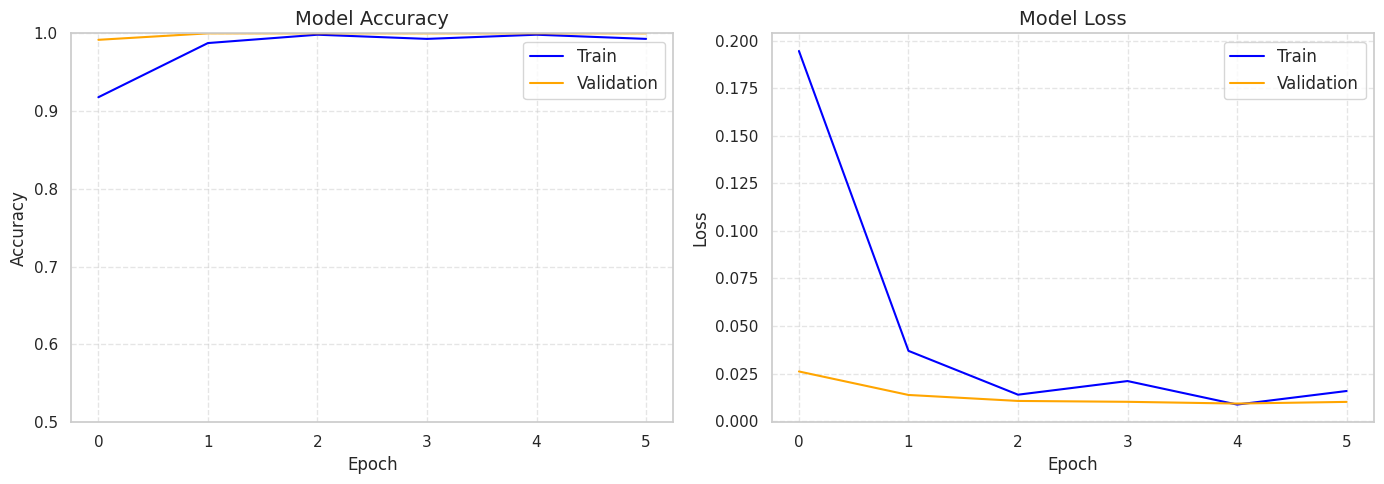

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, applications
import matplotlib.pyplot as plt

# 1. Configuration
IMG_SIZE = (300, 300)
BATCH_SIZE = 32
EPOCHS = 20  # Reduced since convergence occurs by epoch 10
SEED = 42

# 2. Enhanced Data Pipeline
def create_dataset(subset):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join("/kaggle/input/cats-dogs-dataset/CatDog2", subset),
        label_mode='binary',
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        seed=SEED
    )
    return ds.map(lambda x, y: (applications.efficientnet_v2.preprocess_input(x), y),
               num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

train_ds = create_dataset("train")
val_ds = create_dataset("val")

# 3. Improved Augmentation
augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1),  # Added for better generalization
], name="augmentation")

# 4. Enhanced Model Architecture
def build_model():
    base = applications.EfficientNetV2S(
        include_top=False,
        weights='imagenet',
        input_shape=(*IMG_SIZE, 3),
        pooling='avg'
    )
    base.trainable = False

    inputs = layers.Input(shape=(*IMG_SIZE, 3))
    x = augmentation(inputs)
    x = base(x)
    x = layers.Dropout(0.4)(x)  # Increased dropout
    x = layers.Dense(128, activation='swish')(x)  # Reduced units
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    return models.Model(inputs, outputs)

model = build_model()

# 5. Optimized Training Setup
initial_lr = 1e-3  # Higher initial learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=initial_lr),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# 6. Enhanced Callbacks
callbacks = [
    callbacks.EarlyStopping(
        monitor='val_auc',
        patience=5,
        mode='max',
        restore_best_weights=True,
        baseline=0.99  # Stop when val_auc reaches 0.99
    ),
    callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_auc',
        save_best_only=True,
        mode='max'
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6
    )
]

# 7. Training Execution
print("Phase 1: Frozen Base Training")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=2
)

# 8. Final Evaluation
test_ds = create_dataset("test")
test_metrics = model.evaluate(test_ds, verbose=0)
print("\nFinal Test Metrics:")
print(f"- Loss: {test_metrics[0]:.4f}")
print(f"- Accuracy: {test_metrics[1]*100:.2f}%")
print(f"- AUC: {test_metrics[2]:.4f}")

# 9. Professional Visualization
def plot_history(history):
    plt.figure(figsize=(14, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation', color='orange')
    plt.title('Model Accuracy', fontsize=14)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.ylim(0.5, 1.0)  # Fixed y-axis range
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train', color='blue')
    plt.plot(history.history['val_loss'], label='Validation', color='orange')
    plt.title('Model Loss', fontsize=14)
    plt.ylabel('Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig('training_metrics.png', dpi=300)  # Save high-quality plot
    plt.show()

plot_history(history)

Found 122 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 1.0000 - auc: 0.8000 - loss: 0.0247

Test Set Evaluation:
- Loss: 0.0304
- Accuracy: 100.00%
- AUC: 1.0000
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step

Classification Report:
              precision    recall  f1-score   support

         Cat       1.00      1.00      1.00        61
         Dog       1.00      1.00      1.00        61

    accuracy                           1.00       122
   macro avg       1.00      1.00      1.00       122
weighted avg       1.00      1.00      1.00       122



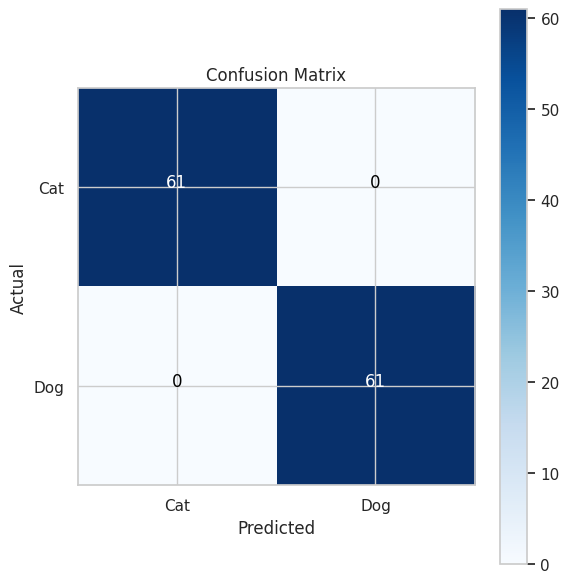

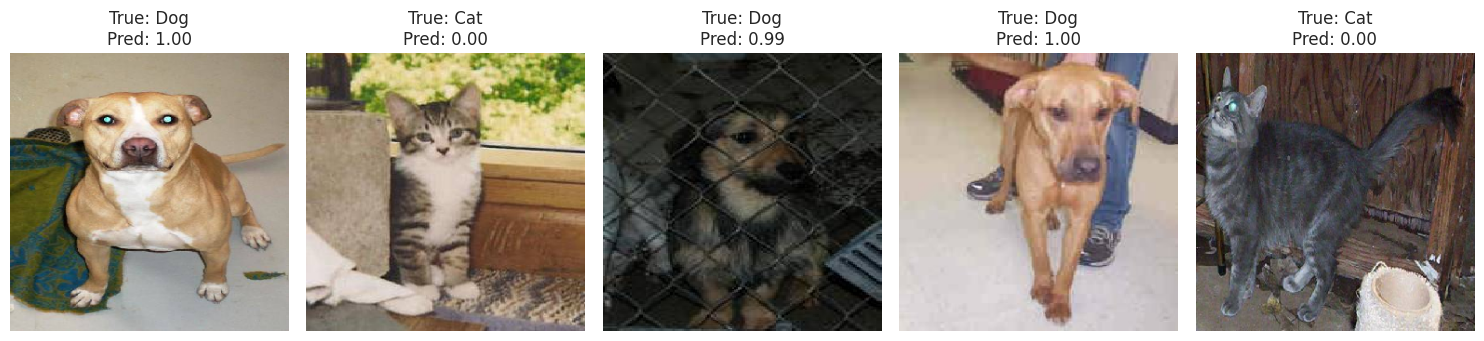

In [24]:
import tensorflow as tf
from tensorflow.keras import metrics
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1. Load the trained model
model = tf.keras.models.load_model('best_model.keras')

# 2. Prepare test dataset (ensure no augmentation)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/cats-dogs-dataset/CatDog2/test',
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Critical for correct label ordering
)

# 3. Full evaluation
test_metrics = model.evaluate(test_generator, verbose=1)
print("\nTest Set Evaluation:")
print(f"- Loss: {test_metrics[0]:.4f}")
print(f"- Accuracy: {test_metrics[1]*100:.2f}%")
print(f"- AUC: {test_metrics[2]:.4f}")

# 4. Detailed predictions analysis
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int)

# 5. Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, 
                           target_names=['Cat', 'Dog']))

# 6. Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Cat', 'Dog'])
plt.yticks(tick_marks, ['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

# 7. Visual inspection of predictions
def visualize_predictions(num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        # Get a random test image
        idx = np.random.randint(0, len(test_generator.filenames))
        img_path = os.path.join(test_generator.directory, test_generator.filenames[idx])
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(300, 300))
        
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f"True: {'Cat' if y_true[idx]==0 else 'Dog'}\nPred: {y_pred[idx][0]:.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('sample_predictions.png', dpi=300)
    plt.show()

visualize_predictions()

Found 122 files belonging to 2 classes.

Test Set Evaluation:
- Accuracy: 100.00%
- Average Confidence: 0.9722

No ambiguous samples found (all predictions with confidence <0.4 or >0.6)


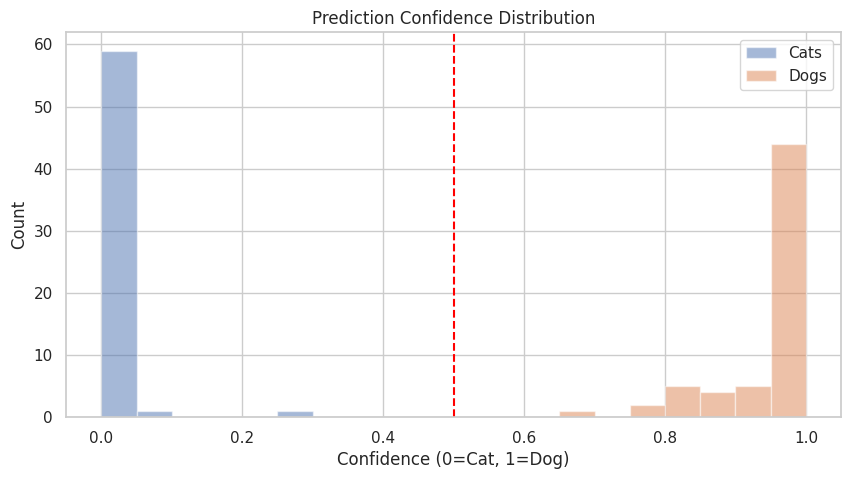

In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import os

# 1. First get all file paths in order
test_dir = '/kaggle/input/cats-dogs-dataset/CatDog2/test'
file_paths = []
for root, _, files in os.walk(test_dir):
    for file in sorted(files):  # Sort for consistent ordering
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            file_paths.append(os.path.join(root, file))

# 2. Create test dataset with matching order
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(300, 300),
    batch_size=32,
    shuffle=False  # Critical for matching file_paths order
).map(lambda x,y: (tf.keras.applications.efficientnet_v2.preprocess_input(x), y))

# 3. Get predictions and true labels
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    y_pred.extend(model.predict(images, verbose=0))
    
y_true = np.array(y_true)
y_pred = np.array(y_pred).flatten()
y_pred_classes = (y_pred > 0.5).astype(int)

# 4. Evaluation metrics
print("\nTest Set Evaluation:")
print(f"- Accuracy: {np.mean(y_true == y_pred_classes)*100:.2f}%")
print(f"- Average Confidence: {np.mean(np.where(y_pred_classes==1, y_pred, 1-y_pred)):.4f}")

# 5. Find ambiguous predictions (0.4-0.6 confidence)
ambiguous_mask = (y_pred > 0.4) & (y_pred < 0.6)
ambiguous_indices = np.where(ambiguous_mask)[0]

if len(ambiguous_indices) > 0:
    print(f"\nFound {len(ambiguous_indices)} potentially ambiguous samples:")
    plt.figure(figsize=(15, min(5, len(ambiguous_indices)*3)))
    for i, idx in enumerate(ambiguous_indices[:5]):  # Show max 5
        img = tf.keras.preprocessing.image.load_img(file_paths[idx], target_size=(300, 300))
        plt.subplot(1, min(5, len(ambiguous_indices)), i+1)
        plt.imshow(img)
        plt.title(f"True: {'Cat' if y_true[idx]==0 else 'Dog'}\nPred: {y_pred[idx]:.4f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo ambiguous samples found (all predictions with confidence <0.4 or >0.6)")

# 6. Confidence distribution plot
plt.figure(figsize=(10, 5))
plt.hist(y_pred[y_true==0], bins=20, alpha=0.5, label='Cats', range=(0,1))
plt.hist(y_pred[y_true==1], bins=20, alpha=0.5, label='Dogs', range=(0,1))
plt.axvline(0.5, color='red', linestyle='--')
plt.title('Prediction Confidence Distribution')
plt.xlabel('Confidence (0=Cat, 1=Dog)')
plt.ylabel('Count')
plt.legend()
plt.show()